# Intro 
We want to analyse cafe sales to provide valuable insights into customer behavior, product popularity and revenue patterns.

# Step 1. Read & Inspect Dataframe

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Read csv
df = pd.read_csv("/kaggle/input/cafe-sales-dirty-data-for-cleaning-training/dirty_cafe_sales.csv")
# Copy dataset for cleaning
df_clean = df.copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


# Step 2. Perform data cleaning
* Convert total spent, quantity and price per unit columns to numeric data type
* Populate missing values
* Convert transaction date to datetime data type
* Add column transaction month

In [2]:
# Unique prices dict
unique_prices = {
    'Cookie': 1.0,
    'Tea': 1.5,
    'Coffee': 2.0,
    'Salad': 5.0
}

# Non unique Prices dict
non_unique_prices = {
    'Juice': 3.0,
    'Cake': 3.0,
    'Sandwich': 4.0,
    'Smoothie': 4.0
}

# Combined prices dict
prices = unique_prices | non_unique_prices

# Convert to numeric
df_clean[['Total Spent', 'Quantity', 'Price Per Unit']] = df_clean[['Total Spent', 'Quantity', 'Price Per Unit']].apply(pd.to_numeric, errors='coerce', axis=1)

# Populate Price Per Unit (1.Based on Item, 2.Total Spent / Quantity)
df_clean['Price Per Unit'] = df_clean.apply(lambda row: prices.get(row['Item']) if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)
df_clean['Price Per Unit'] = df_clean.apply(lambda row: row['Total Spent'] / row['Quantity'] if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)
# Drop rows where Price Per Unit is NaN (6 rows)
df_clean.dropna(subset=['Price Per Unit'], inplace=True)
# Drop rows where Total Spent & Quantity is NaN (20 rows)
df_clean.dropna(subset=['Total Spent', 'Quantity'], how='all', inplace=True)

# Populate Total Spent (Quantity * Price Per Unit)
df_clean['Total Spent'] = df_clean.apply(lambda row: row['Quantity'] * row['Price Per Unit'] if pd.isna(row['Total Spent']) else row['Total Spent'], axis=1)

# Populate Quantity (Total Spent / Price Per Unit)
df_clean['Quantity'] = df_clean.apply(lambda row: row['Total Spent'] * row['Price Per Unit'] if pd.isna(row['Quantity']) else row['Quantity'], axis=1)

# Convert UNKNOWN & ERROR items to NaN (963 rows)
df_clean['Item'] = df_clean['Item'].replace({'UNKNOWN': np.nan, 'ERROR': np.nan})
df_clean[df_clean['Item'].isna()]
# Populate Item (Based on unique prices) 
df_clean['Item'] = df_clean.apply(lambda row: next((k for k, v in unique_prices.items() if v == row['Price Per Unit']), row['Item']), axis=1)

# Convert to date 
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')
# Drop rows where Transaction Date is NaN
df_clean.dropna(subset=['Transaction Date'], inplace=True)
# Add new column 'Transaction Month'
df_clean['Transaction Month'] = pd.to_datetime(df_clean['Transaction Date']).dt.strftime('%B')

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9514 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Transaction ID     9514 non-null   object        
 1   Item               9064 non-null   object        
 2   Quantity           9514 non-null   float64       
 3   Price Per Unit     9514 non-null   float64       
 4   Total Spent        9514 non-null   float64       
 5   Payment Method     7084 non-null   object        
 6   Location           6404 non-null   object        
 7   Transaction Date   9514 non-null   datetime64[ns]
 8   Transaction Month  9514 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 743.3+ KB


# Step 3. Data Aggregation

In [3]:
# Quantity Sold Per Month
df_quantities_pivot = df_clean.pivot_table(index='Transaction Month', columns='Item', values='Quantity', aggfunc='sum')
df_quantities_pivot.reset_index(inplace=True)
df_quantities_pivot['Transaction Month No'] = pd.to_datetime(df_quantities_pivot['Transaction Month'], format='%B').dt.month
df_quantities_pivot.sort_values('Transaction Month No', inplace=True)
df_quantities_pivot.drop(columns='Transaction Month No', inplace=True)

# Add column 'Monthly Revenue'
df_quantities_pivot['Monthly Revenue'] = df_quantities_pivot[list(prices.keys())].sum(axis=1)
df_quantities_pivot

# Revenue by Item 
revenue = df_clean.groupby('Item')['Total Spent'].agg(['sum']).sort_values(by='sum', ascending=False)

# Step 4. Create Plots
Three subplots will be created to show the revenue by item, top 3 selling items and monthly revenue.

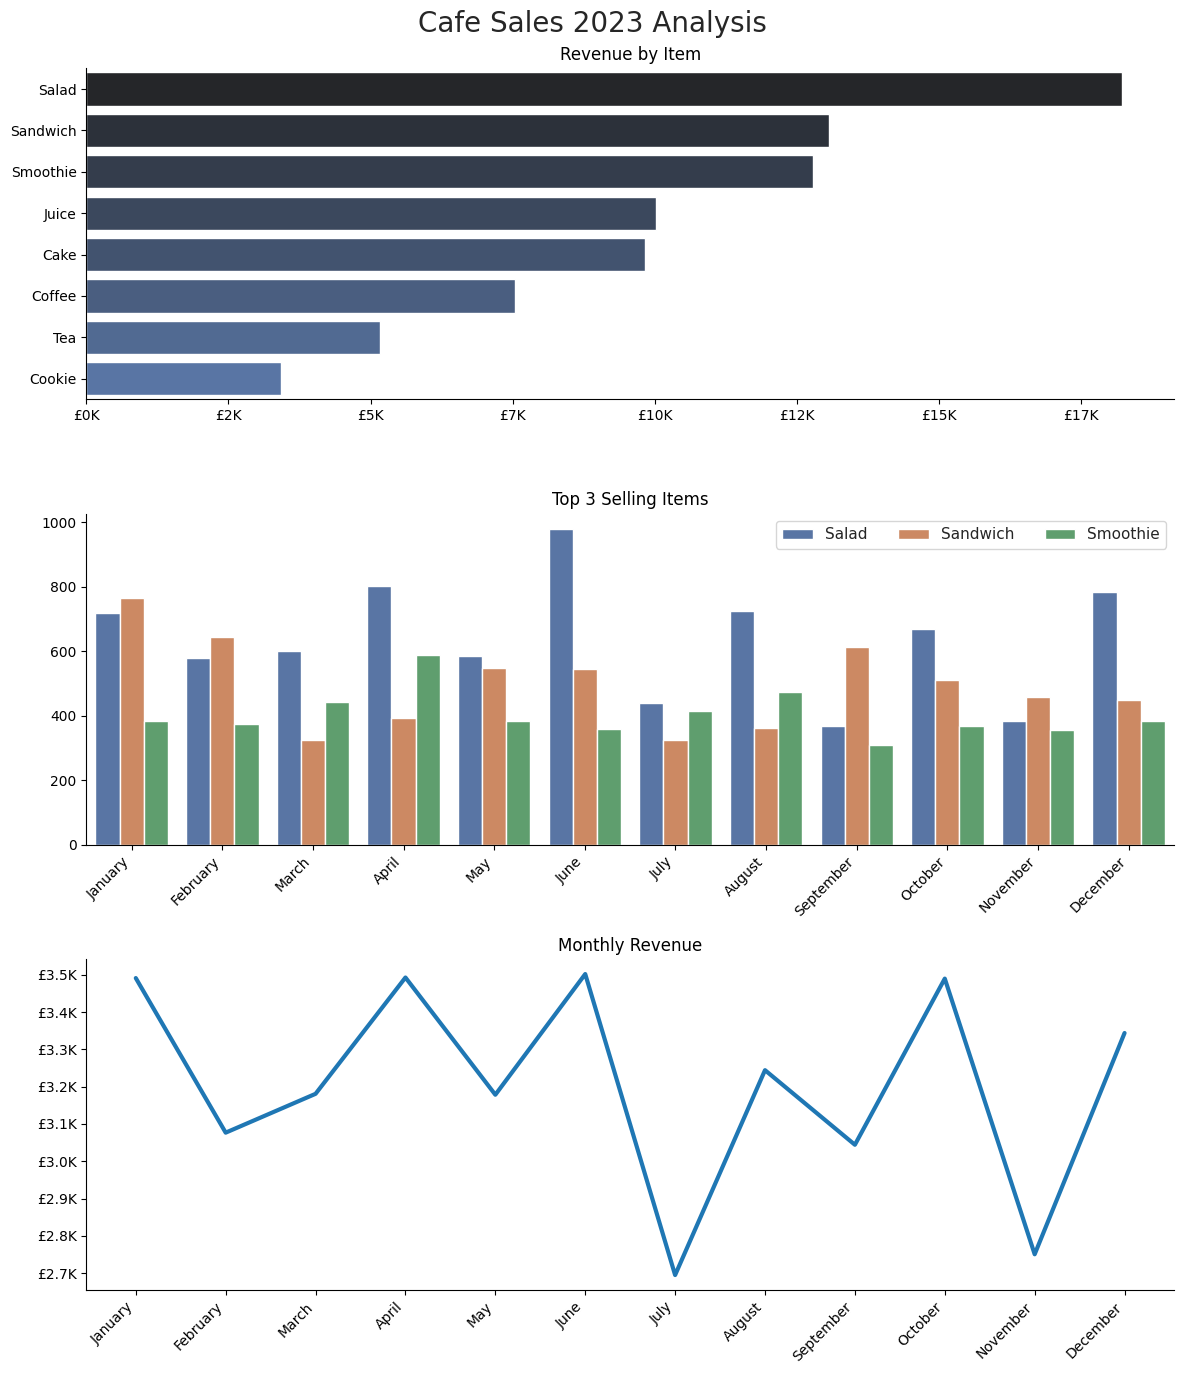

In [4]:
fig, ax = plt.subplots(3,1, figsize=(12,14))

# Revenue by Item
sns.set_theme(style='ticks')
sns.barplot(data=revenue, x='sum', y=revenue.index, palette='dark:b', ax=ax[0])
sns.despine()
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Revenue by Item')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x/1000)}K'))

# Top 3 Selling Items
top_3 = df_clean.groupby('Item')['Quantity'].agg(['sum']).sort_values(by='sum', ascending=False)
top_3 = top_3.head(3).index.tolist()
df_top_3 = df_quantities_pivot.melt(id_vars='Transaction Month', value_vars=top_3, var_name='Item', value_name='Quantity')
sns.barplot(data=df_top_3, x='Transaction Month', y='Quantity', hue='Item', ax=ax[1])
ax[1].set_title('Top 3 Selling Items')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].legend(loc='upper right', ncol=3)

# Monthly Revenue
sns.lineplot(data=df_quantities_pivot, x='Transaction Month', y='Monthly Revenue', linewidth=3)
ax[2].set_title('Monthly Revenue')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x/1000:.1f}K'))
plt.setp(ax[2].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Cafe Sales 2023 Analysis', fontsize=20)
fig.tight_layout()

# Step 5. Analysis
**Revenue by Item**
We can observe that salad generated the highest revenue, earning approximately \$5k more than the second-highest item, while cookie generated the lowest revenue.

**Top 3 Selling Items**
Month by month, salad is usually the most purchased item, with sales peaking in June as summer begins. Sales dip in September, likely due to the arrival of autumn, but overall, this pattern indicates that people are health conscious. Sandwiches and smoothies are also among the top selling items, further supporting the trend of health conscious consumer choices. This aligns with the fact that the highest revenue-generating items are salads, sandwiches and smoothies.

**Monthly Revenue**
The monthly revenue remains consistently around \$3k+, except for July and November, when it slightly drops. The revenue drop in July could be attributed to it being part of the summer season, where people may be on vacation or spending more time outdoors for activities, holidays, or travel, leading to fewer visits to the cafe. In November, the decline might be due to the approach of winter, as people tend to focus more on indoor, home-based activities. Additionally, with the preparations for holidays like Thanksgiving, customers might shift their spending towards family gatherings or holiday-related activities rather than dining out. A promotion could be a good strategy to boost revenue during the lower performing months. January, April, June, and October are the top-performing months in terms of revenue generation.
